In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

### DCP

In [3]:
def my_cumulative_sum(input_image, r):
    height, width = input_image.shape
    cumulative_sum = np.zeros_like(input_image)

    # Calculate cumulative sum for columns
    cumulative = np.cumsum(input_image, axis=0)
    cumulative_sum[:r+1, :] = cumulative[r:2*r+1, :]
    cumulative_sum[r+1:height-r, :] = cumulative[2*r+1:height, :] - cumulative[:height-2*r-1, :]
    cumulative_sum[height-r:, :] = np.tile(cumulative[height-1, :], (r, 1)) - cumulative[height-2*r-1:height-r-1, :]

    # Calculate cumulative sum for rows
    cumulative = np.cumsum(cumulative_sum, axis=1)
    cumulative_sum[:, :r+1] = cumulative[:, r:2*r+1]
    cumulative_sum[:, r+1:width-r] = cumulative[:, 2*r+1:width] - cumulative[:, :width-2*r-1]
    cumulative_sum[:, width-r:] = np.tile(cumulative[:, width-1][:, np.newaxis], (1, r)) - cumulative[:, width-2*r-1:width-r-1]

    return cumulative_sum

def my_minfilter(I, window_size):
    I_new = I.copy()
    height, width = I.shape

    for i in range(height):
        for j in range(width):
            i_down = max(0, i - window_size)
            i_up = min(height, i + window_size + 1)
            j_down = max(0, j - window_size)
            j_up = min(width, j + window_size + 1)
            
            I_new[i, j] = np.min(I[i_down:i_up, j_down:j_up])

    return I_new

def my_darkchannel(I, window_size):
    height, width, _ = I.shape
    dark_channel = np.ones((height, width))

    for i in range(height):
        for j in range(width):
            dark_channel[i, j] = np.min(I[i, j, :])

    min_dark_channel = my_minfilter(dark_channel, window_size)
    return min_dark_channel

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def my_estimateA(I, dark_channel):
    A = np.zeros((1, 1, 3))
    height, width = dark_channel.shape

    points_number = round(width * height * 0.001)

    for _ in range(points_number):
        # brightest_points = np.max(dark_channel)
        i, j = np.unravel_index(np.argmax(dark_channel), dark_channel.shape)
        
        dark_channel[i, j] = 0

        if np.mean(I[i, j, :]) > np.mean(A):
            A[0, 0, :] = (A[0, 0, :] + I[i, j, :]) / 2

    return A

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz)
    imvec = im.reshape(imsz,3)

    indices = darkvec.argsort()
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx
    return A

def my_guidedfilter(guide_image, I, radius, smooth_parameter):
    height, width = guide_image.shape
    N = my_cumulative_sum(np.ones((height, width)), radius)

    mean_guide = my_cumulative_sum(guide_image, radius) / N
    mean_I = my_cumulative_sum(I, radius) / N
    mean_IG = my_cumulative_sum(guide_image * I, radius) / N
    cov_IG = mean_IG - mean_guide * mean_I
    mean_II = my_cumulative_sum(guide_image * guide_image, radius) / N
    var_I = mean_II - mean_guide * mean_guide

    a = cov_IG / (var_I + smooth_parameter)
    b = mean_I - a * mean_guide

    mean_a = my_cumulative_sum(a, radius) / N
    mean_b = my_cumulative_sum(b, radius) / N

    q = mean_a * guide_image + mean_b
    return q


In [19]:
def run_DCP(I):
    
    # plt.figure()
    # plt.imshow(I)
    # plt.title(f"Original Image {image_name}")
    # plt.show()

    height, width, _ = I.shape

    I = I.astype(np.float32) / 255.0
    # Get dark channel
    window_size = 15
    # dark_channel = my_darkchannel(I, window_size)
    dark_channel = DarkChannel(I, window_size)
    # dark_channel = dark_channel / 255.0

    plt.figure()
    plt.imshow(dark_channel, cmap='gray')
    plt.title(f"dark")
    plt.show()

    # Calculate atmospheric light A
    # A = my_estimateA(I, dark_channel)
    A = AtmLight(I, dark_channel)

    # Calculate transmission matrix t(x)
    w = 0.95
    t = 1 - w * dark_channel / np.mean(A)

    plt.imshow(t, cmap='gray')
    plt.title(f"Transmission")
    plt.show()

    I_gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    t1 = my_guidedfilter(I_gray, t, 65, 0.0001)
    t2 = my_guidedfilter(t1, t1, 7, 0.03)

    plt.imshow(t2, cmap='gray')
    plt.title(f"Transmission Refined")
    plt.show()

    t_threshold = 0.005
    t = np.maximum(t2, t_threshold)
    
    # Recover haze-free image
    K = 0.1
    defog_image = np.zeros_like(I)

    # # for i in range(3):
    # #     defog_image[:,:,i] = ((I[:,:,i] - A[0,0,i]) / 
    # #                             np.minimum(1, t * np.maximum(K / np.abs(I[:,:,i] - A[0,0,i]), 1))) + A[0,0,i]
        
    
    # for i in range(3):
    #     defog_image[:,:,i] = ((I[:,:,i] - A[0,i]) / 
    #                             np.minimum(0.85, t * np.maximum(K / (np.abs(I[:,:,i]+0.000001) - A[0,i]), 0.85))) + A[0,i]

    for i in range(3):
        defog_image[:,:,i] = (I[:,:,i] - A[0,i]) / t + A[0,i]

    defog_image = defog_image * 1.1
    defog_image = np.clip(defog_image, 0, 1)

    defog_image = defog_image * 255.0
    
    return defog_image.astype(np.uint8)



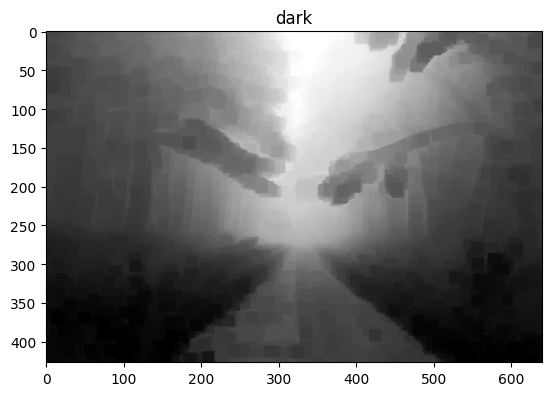

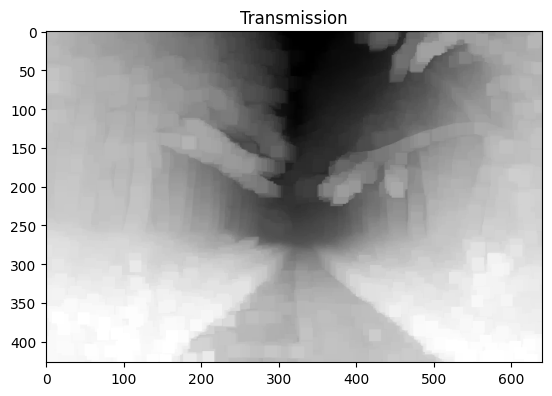

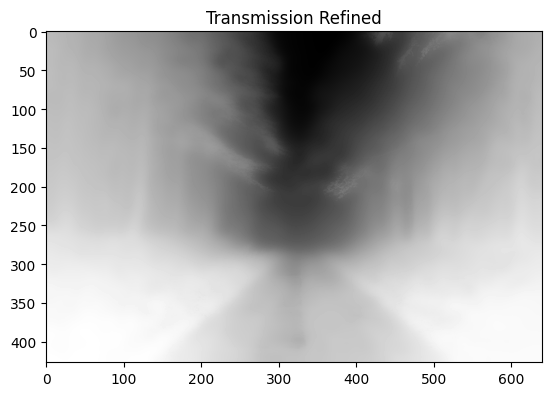

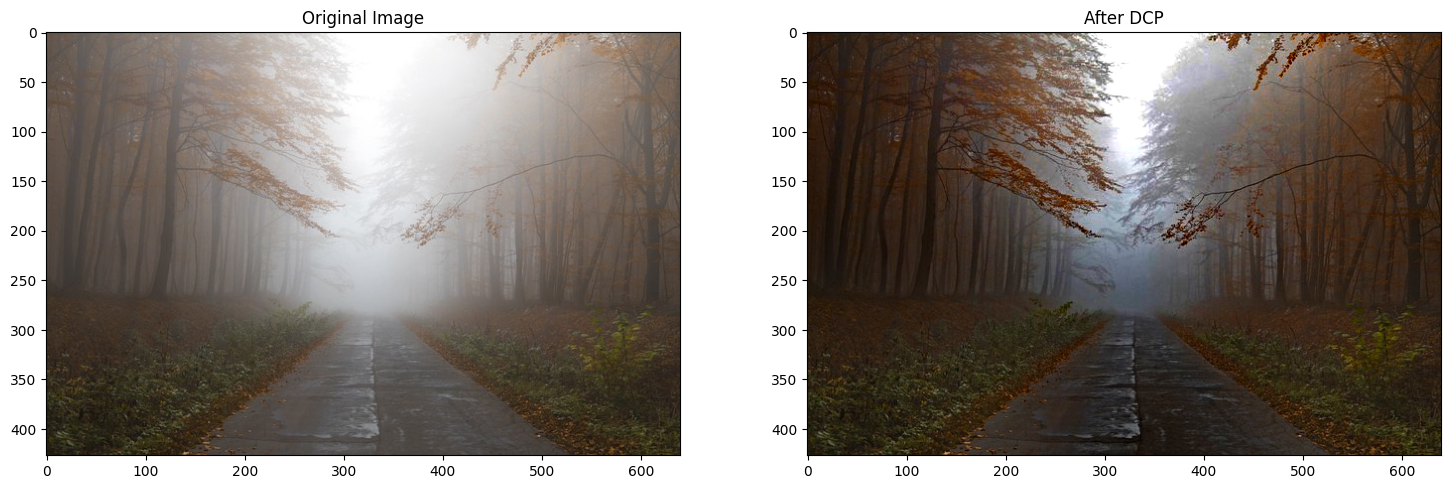

In [20]:
images = [
    "./images/autumn.jpg"
]

for image in images:
    inp = cv2.imread(image)
    res = run_DCP(inp)
    
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(inp, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.title(f"After DCP")
    plt.show()

---
### CLAHE

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def my_clip_histogram(hist, sum_pixel_bin, clip_limit, subpart_x, subpart_y):
    """
    Clip histogram to limit contrast enhancement
    """
    for i in range(subpart_x):
        for j in range(subpart_y):
            # Calculate excess histogram values
            sum_excess = 0
            for nr in range(sum_pixel_bin):
                excess = hist[i, j, nr] - clip_limit
                if excess > 0:
                    sum_excess += excess

            # Redistribute excess histogram values
            bin_average = sum_excess / sum_pixel_bin
            upper = clip_limit - bin_average

            for nr in range(sum_pixel_bin):
                if hist[i, j, nr] > clip_limit:
                    hist[i, j, nr] = clip_limit
                else:
                    if hist[i, j, nr] > upper:
                        sum_excess += upper - hist[i, j, nr]
                        hist[i, j, nr] = clip_limit
                    else:
                        sum_excess -= bin_average
                        hist[i, j, nr] += bin_average

            # Distribute remaining excess
            if sum_excess > 0:
                step_size = max(1, int(1 + sum_excess / sum_pixel_bin))
                for nr in range(sum_pixel_bin):
                    sum_excess -= step_size
                    hist[i, j, nr] += step_size
                    if sum_excess < 1:
                        break

    return hist

def my_map_histogram(hist, min_pixel, max_pixel, sum_pixel_bins, sum_pixels, subpart_x, subpart_y):
    """
    Map histogram to output range
    """
    output = np.zeros((subpart_x, subpart_y, sum_pixel_bins))
    scale = (max_pixel - min_pixel) / sum_pixels

    for i in range(subpart_x):
        for j in range(subpart_y):
            cumsum = 0
            for nr in range(sum_pixel_bins):
                cumsum += hist[i, j, nr]
                output[i, j, nr] = min(min_pixel + cumsum * scale, max_pixel)

    return output

def my_adapthisteq(img_gray):
    """
    Adaptive Histogram Equalization implementation
    """
    # Ensure image is float type
    img_gray = img_gray.astype(np.float32)

    # Get image dimensions
    height, width = img_gray.shape

    # Get pixel value range
    min_pixel = np.min(img_gray)
    max_pixel = np.max(img_gray)

    # Image subdivision
    subpart_y = max(1, int(width / 100) - 2)
    subpart_x = max(1, int(height / 100) - 1)

    height_size = int(np.ceil(height / subpart_x))
    width_size = int(np.ceil(width / subpart_y))

    # Adjust image dimensions to ensure perfect division
    delta_y = subpart_x * height_size - height
    delta_x = subpart_y * width_size - width

    # Pad image
    temp_image = np.zeros((height + delta_y, width + delta_x), dtype=np.float32)
    temp_image[:height, :width] = img_gray

    new_width = width + delta_x
    new_height = height + delta_y
    sum_pixels = width_size * width_size

    # Pixel bin mapping
    sum_pixel_bins = 256
    
    # Create pixel bin with proper indexing
    pixel_bin = np.zeros_like(temp_image, dtype=np.int32)
    for m in range(temp_image.shape[0]):
        for n in range(temp_image.shape[1]):
            # Ensure value is within 0-255 range and add 1 for 1-based indexing
            pixel_bin[m, n] = min(max(0, int(temp_image[m, n])), 255) + 1

    # Create histogram
    hist = np.zeros((subpart_x, subpart_y, 256), dtype=np.float32)
    for i in range(subpart_x):
        for j in range(subpart_y):
            sub_img = pixel_bin[i * height_size:(i + 1) * height_size, 
                                 j * width_size:(j + 1) * width_size]
            hist[i, j, :], _ = np.histogram(sub_img, bins=256, range=(1, 257))

    # Clip histogram
    clip_limit = 2.5
    clip_limit = max(1, clip_limit * height_size * width_size / sum_pixel_bins)
    hist = my_clip_histogram(hist, sum_pixel_bins, clip_limit, subpart_x, subpart_y)

    # Map histogram
    map_output = my_map_histogram(hist, min_pixel, max_pixel, sum_pixel_bins, sum_pixels, subpart_x, subpart_y)

    # Bilinear interpolation for output
    output = np.zeros_like(pixel_bin, dtype=np.float32)
    y_i = 0
    for i in range(subpart_x + 1):
        # Handle row boundaries
        if i == 0:
            sub_y = int(height_size / 2)
            y_up = 0
            y_bottom = 0
        elif i == subpart_x:
            sub_y = int(height_size / 2)
            y_up = subpart_x - 1
            y_bottom = subpart_x - 1
        else:
            sub_y = height_size
            y_up = i - 1
            y_bottom = i

        x_i = 0
        for j in range(subpart_y + 1):
            # Handle column boundaries
            if j == 0:
                sub_x = int(width_size / 2)
                x_left = 0
                x_right = 0
            elif j == subpart_y:
                sub_x = int(width_size / 2)
                x_left = subpart_y - 1
                x_right = subpart_y - 1
            else:
                sub_x = width_size
                x_left = j - 1
                x_right = j

            # Interpolation
            u_l = map_output[y_up, x_left, :]
            u_r = map_output[y_up, x_right, :]
            b_l = map_output[y_bottom, x_left, :]
            b_r = map_output[y_bottom, x_right, :]

            sub_image = pixel_bin[y_i:y_i + sub_y, x_i:x_i + sub_x]
            s_image = np.zeros_like(sub_image, dtype=np.float32)

            for m in range(sub_y):
                for n in range(sub_x):
                    val = sub_image[m, n] - 1  # Adjust index
                    s_image[m, n] = (
                        (sub_y - m) * ((sub_x - n) * u_l[val] + n * u_r[val]) +
                        m * ((sub_x - n) * b_l[val] + n * b_r[val])
                    ) / (sub_y * sub_x)

            output[y_i:y_i + sub_y, x_i:x_i + sub_x] = s_image
            x_i += sub_x

        y_i += sub_y

    # Crop back to original dimensions
    output = output[:height, :width]
    return output.astype(np.uint8)

def run_CLAHE(img):
    """
    Process multiple images using CLAHE
    """

    # Convert to LAB color space
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_img)

    # Apply adaptive histogram equalization to L channel
    l_enhanced = my_adapthisteq(l_channel)

    # Subtract 50 from L channel
    l_enhanced = np.clip(l_enhanced.astype(np.float32) - 40, 0, 255).astype(np.uint8)

    # Merge channels back
    enhanced_lab_img = cv2.merge([l_enhanced, a_channel, b_channel])

    # Convert back to BGR
    enhanced_img = cv2.cvtColor(enhanced_lab_img, cv2.COLOR_LAB2BGR)

    # Increase brightness
    enhanced_img = np.clip(1.3 * enhanced_img, 0, 255).astype(np.uint8)

    return enhanced_img

In [7]:
def CLAHE_DCP(images, weighted=False):
    for image_path in images:
        img = cv2.imread(image_path)

        after_CLAHE = run_CLAHE(img)
        after_DCP = (
            run_DCP(after_CLAHE * 0.5 + img * 0.5)
            if weighted
            else run_DCP(after_CLAHE)
        )

        only_DCP = run_DCP(img)

        plt.figure(figsize=(20, 12))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"original image")

        # plt.subplot(1, 3, 2)
        # plt.imshow(cv2.cvtColor(after_CLAHE, cv2.COLOR_BGR2RGB))
        # plt.axis("off")
        # plt.title(f"only CLAHE")

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(after_DCP, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"CLAHE + DCP")

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(only_DCP, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"only DCP")

        plt.show()

### Pipeline

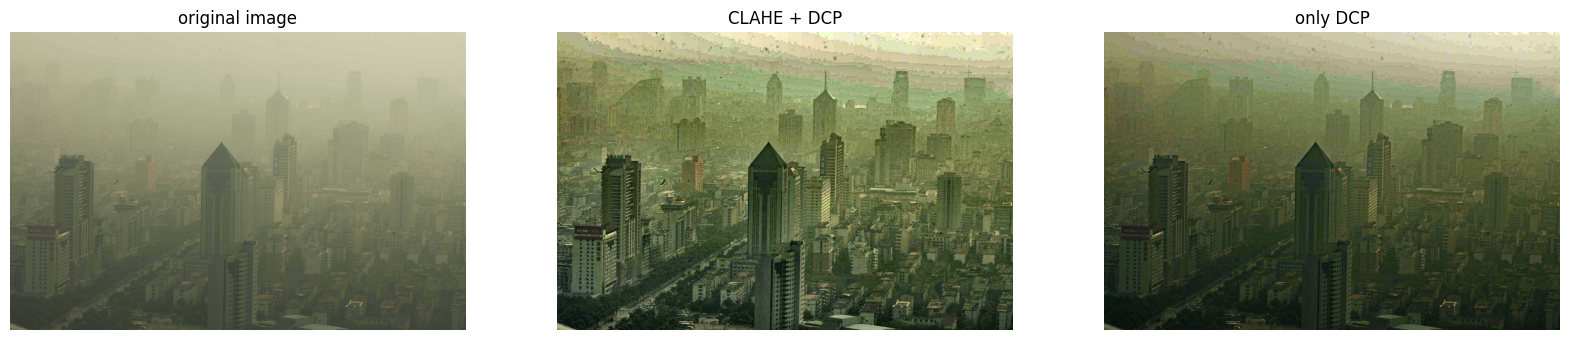

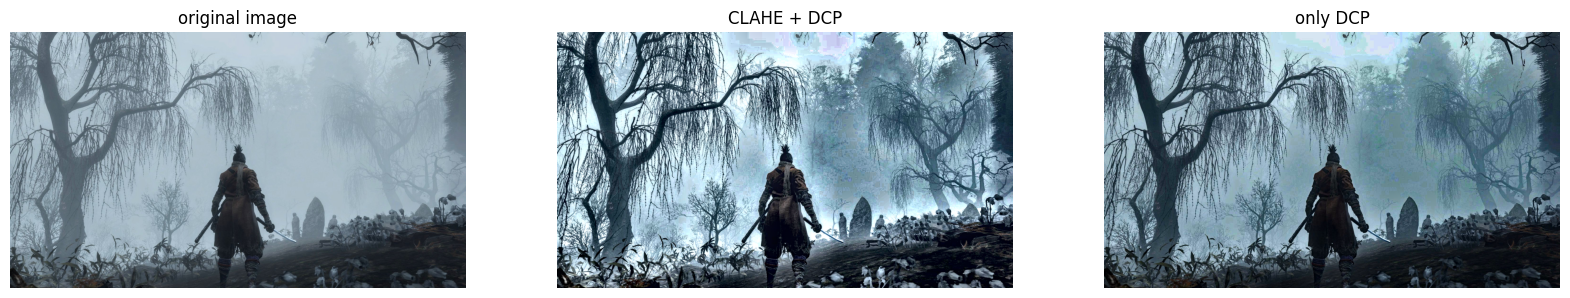

In [15]:
folder = "./images/new_images"

images = [
    f"{folder}/{i}.jpg" for i in range(1, 2)
    ]
# images.append("./images/pumpkins.jpg")
# images.append("./images/autumn.jpg")
# images.append("./images/autoo.jpg")
images.append("./images/sekiro.jpg")
CLAHE_DCP(images)

In [308]:
folder = "./images"

images = [
    f"{folder}/carrrr.png",
    f"{folder}/delhi.png",
    f"{folder}/foggy_lil.png",
    f"{folder}/test_d1.png",
    f"{folder}/test_paper.png",
    f"{folder}/test1.png",
    f"{folder}/pumpkins.jpg",
]

# CLAHE_DCP(images, weighted=False)

### CAP

In [11]:
import sys,os
import cv2
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

# from GuidedFilter import GuidedFilter
class GuidedFilter:
    
    def __init__(self, I, radius=5, epsilon=0.4):

        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = self._toFloatImg(I)
        self._initFilter()

    def _toFloatImg(self, img):
        if img.dtype == np.float32:
            return img
        return ( 1.0 / 255.0 ) * np.float32(img)

    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps                                       
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean                                  
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean                                  
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps                            
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean                                  
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps                                                                                     


        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps                                       
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean                                  
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean                                  
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps                            
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean                                  
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps                                                       


        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var                                                      
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var                                                      
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var                                                      
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var                                                      
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var                                                      
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var                                                      
        
        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var                                    
        Irr_inv /= I_cov                                                                                     
        Irg_inv /= I_cov                                                                                     
        Irb_inv /= I_cov                                                                                     
        Igg_inv /= I_cov                                                                                     
        Igb_inv /= I_cov                                                                                     
        Ibb_inv /= I_cov                                                                                     
        
        self._Irr_inv = Irr_inv                                                                              
        self._Irg_inv = Irg_inv                                                                              
        self._Irb_inv = Irb_inv                                                                              
        self._Igg_inv = Igg_inv                                                                              
        self._Igb_inv = Igb_inv                                                                              
        self._Ibb_inv = Ibb_inv                  

    def _computeCoefficients(self, p):
        r = self._radius                                                             
        I = self._I                                                                 
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]                                                          
        

        p_mean = cv2.blur(p, (r, r))                             
        Ipr_mean = cv2.blur(Ir * p, (r, r))                                                         
        Ipg_mean = cv2.blur(Ig * p, (r, r))                                                    
        Ipb_mean = cv2.blur(Ib * p, (r, r))             



        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean                                                 
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean                                                     
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean                                                       
                                                                                                                 
        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov                 
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov                
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov    

        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean                                                                                                                                         

        ar_mean = cv2.blur(ar, (r, r))          
        ag_mean = cv2.blur(ag, (r, r))                                                                   
        ab_mean = cv2.blur(ab, (r, r))                                                                      
        b_mean = cv2.blur(b, (r, r))                                                                                                                                              

        return ar_mean, ag_mean, ab_mean, b_mean            

    def _computeOutput(self, ab, I):
    
        ar_mean, ag_mean, ab_mean, b_mean = ab
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]
        q = ar_mean * Ir + ag_mean * Ig + ab_mean * Ib + b_mean
        return q

    def filter(self, p):        
        ab = self._computeCoefficients(p)
        return self._computeOutput(ab, self._I)






def calDepthMap(I, r):
    # Calculate depth map
    hsvI = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
    s = hsvI[:,:,1] / 255.0
    v = hsvI[:,:,2] / 255.0
    #cv2.imshow("hsvI",hsvI)
    #cv2.waitKey()

    sigma = 0.041337
    sigmaMat = np.random.normal(0, sigma, (I.shape[0], I.shape[1]))

    output =  0.121779 + 0.959710 * v - 0.780245 * s + sigmaMat
    outputPixel = output
    output = scipy.ndimage.minimum_filter(output,(r,r))
    outputRegion = output
    # cv2.imwrite("data/vsFeature.jpg", outputRegion*255 )
    #cv2.imshow("outputRegion",outputRegion)
    #cv2.waitKey()
    return outputRegion, outputPixel

def estA(img, Jdark):
    # Estimate the value of atmospheric ambient light A
    h,w,c = img.shape
    if img.dtype == np.uint8:
        img = np.float32(img) / 255
    
    # Compute number for 0.1% brightest pixels
    n_bright = int(np.ceil(0.001*h*w))
    #  Loc contains the location of the sorted pixels
    reshaped_Jdark = Jdark.reshape(1,-1)
    Y = np.sort(reshaped_Jdark) 
    Loc = np.argsort(reshaped_Jdark)
    
    # column-stacked version of I
    Ics = img.reshape(1, h*w, 3)
    ix = img.copy()
    dx = Jdark.reshape(1,-1)
    
    # init a matrix to store candidate airlight pixels
    Acand = np.zeros((1, n_bright, 3), dtype=np.float32)
    # init matrix to store largest norm arilight
    Amag = np.zeros((1, n_bright, 1), dtype=np.float32)
    
    # Compute magnitudes of RGB vectors of A
    for i in range(n_bright):
        x = Loc[0,h*w-1-i]
        ix[x//w, x%w, 0] = 0
        ix[x//w, x%w, 1] = 0
        ix[x//w, x%w, 2] = 1
        
        Acand[0, i, :] = Ics[0, Loc[0, h*w-1-i], :]
        Amag[0, i] = np.linalg.norm(Acand[0,i,:])
    
    # Sort A magnitudes
    reshaped_Amag = Amag.reshape(1,-1)
    Y2 = np.sort(reshaped_Amag) 
    Loc2 = np.argsort(reshaped_Amag)
    # A now stores the best estimate of the airlight
    if len(Y2) > 20:
        A = Acand[0, Loc2[0, n_bright-19:n_bright],:]
    else:
        A = Acand[0, Loc2[0,n_bright-len(Y2):n_bright],:]
    
    # finds the max of the 20 brightest pixels in original image
    # print(A)

    #cv2.imshow("brightest",ix)
    #cv2.waitKey()
    # cv2.imwrite("data/position_of_the_atmospheric_light.png", ix*255)
    
    return A

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


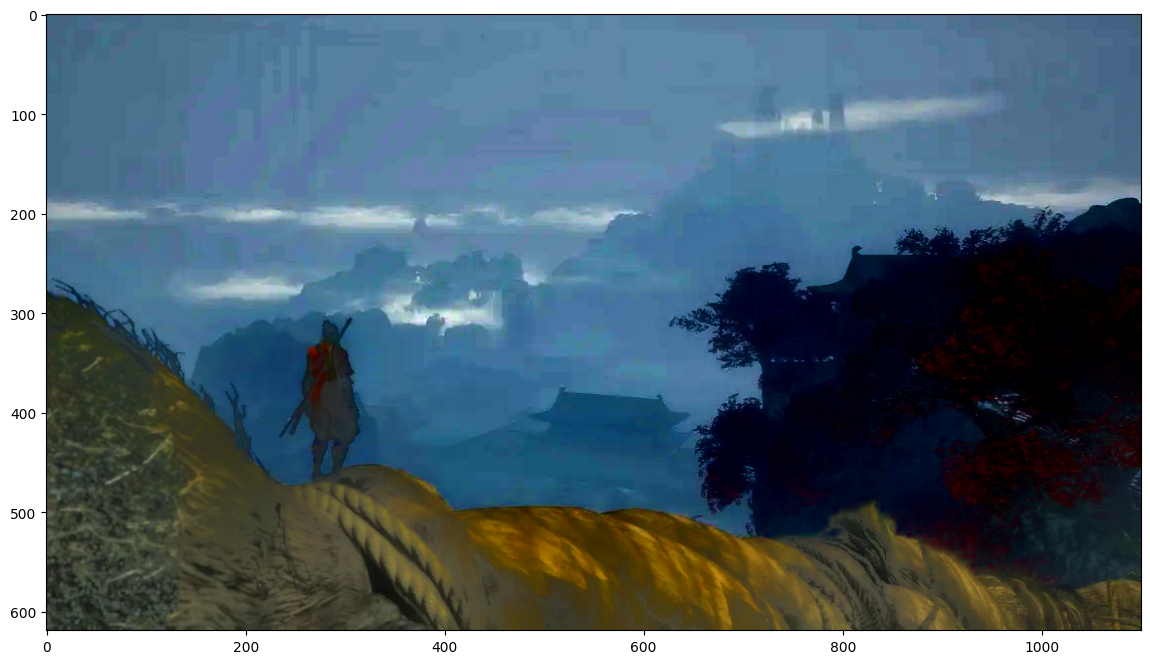

In [14]:
inputImagePath = "./images/sekiro.jpg"


r = 10 # box size for minimum value ; 15
beta = 2.0 # scattering coefficient
gimfiltR = 60 # radius when guiding filtering
eps = 10**-3 # epsilon for guiding filter


I = cv2.imread(inputImagePath)
dR,dP = calDepthMap(I, r)
guided_filter = GuidedFilter(I, gimfiltR, eps)
refineDR = guided_filter.filter(dR)
tR = np.exp(-beta * refineDR)
tP = np.exp(-beta * dP)

# cv2.imwrite("data/originalDepthMap.png", dR*255)
# cv2.imwrite("data/refineDepthMap.png", refineDR*255)
# cv2.imwrite("data/transmission.png", tR*255)

a = estA(I, dR)

if I.dtype == np.uint8:
    I = np.float32(I) / 255

h,w,c = I.shape
J = np.zeros((h, w, c), dtype=np.float32)

J[:,:,0] = I[:,:,0] - a[0,0]
J[:,:,1] = I[:,:,1] - a[0,1]
J[:,:,2] = I[:,:,2] - a[0,2]

t = tR
t0, t1 = 0.05, 1
t = t.clip(t0, t1)

J[:, :, 0] = J[:, :, 0]  / t
J[:, :, 1] = J[:, :, 1]  / t
J[:, :, 2] = J[:, :, 2]  / t

J[:, :, 0] = J[:, :, 0]  + a[0, 0]
J[:, :, 1] = J[:, :, 1]  + a[0, 1]
J[:, :, 2] = J[:, :, 2]  + a[0, 2]

# cv2.imwrite("data/"+str(r)+"_beta"+str(beta)+".png", J*255)
plt.figure(figsize=(18, 8))
plt.imshow(cv2.cvtColor(J, cv2.COLOR_BGR2RGB))
plt.show()